# Epoxy-resin polymer thermoset material

Run this notebook to reproduce the Deep Active Subspace (DAS) results for the epoxy resin application. Small variation in the results will occur due to the stochastic nature of the training procedure.

### Reference

*Global ranking of the sensitivity of interaction potential contributions within classical molecular dynamics force fields*, (submitted), 2023.

### Install EasySurrogate

The Deep Active Subspace method is implemented in EasySurrogate. Uncomment to install.

In [1]:
#!pip install easysurrogate==0.24.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import easysurrogate as es
from scipy import linalg, stats
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

Several subroutines specific to this article are located in `../utils/utils.py`. Import this module.

In [3]:
import sys
sys.path.insert(1, '../')
from utils.utils import plot_sensitivity, plot_errors, plot_dist, early_stopping

In [4]:
%matplotlib inline
# save figures at 300 dpi
plt.rcParams['savefig.dpi'] = 300

### Load prior ranges

The JSON file below contains all default values and boundaries used for specifying the Uniform input parameter distributions. 

In [5]:
# Load the EasyVVUQ params dict
priors = json.load(open('./epoxy.params.json', 'r'))

### Load input parameter values

Load the Monte Carlo values of the inputs.

In [6]:
# input parameters
params = pd.read_csv('./data_epoxy/epoxy_inputs.csv')
param_names = params.keys()
params = params.values

# number of samples
n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

# scale inputs within [-1, 1]
p_max = np.array([priors[name]['default'] * 1.15 for name in param_names])
p_min = np.array([priors[name]['default'] * 0.85 for name in param_names])
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

### Load output samples

Load the corresponding Monte Carlo outputs. We used `E11`, the 11 component of the elasticity tensor, and the Poisson ratio.

In [7]:
# Output QoI
QoI = 'E11'
# QoI = 'poisson'

output = pd.read_csv('./data_epoxy/epoxy_%s_output.csv' % (QoI,)).values

### Average over the random seeds (or not)

Each parameter value was replicated several times, changing only the random seed of the initial condition.

In [8]:
average_over_replicas = True

if not average_over_replicas:
    samples = output[:, 0].reshape([-1, 1])
else:
    samples = np.mean(output, axis=1, keepdims=True)

### Select $d$

This is the dimension of the active subspace.

In [9]:
d = 1

###  Set hyperparameters

In [10]:
# number of neurons per hidden layer 
n_hidden_neurons = 10
# number of hidden layer + output layer
n_layers = 3
# activation function
activation = 'tanh'

# mini batch size
batch_size = 32
# max number of epochs
n_epochs_max = 100
# number of mini-batch iterations per epoch
n_iter = int(n_samples / batch_size)

# early stopping parameters
min_delta = 0.001
patience = 3

### Train / test split

In [11]:
# test fraction
test_frac = 0.1
# indices of the test set
test_idx = int((1 - test_frac) * n_samples)
# training set
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
# test set
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select how many replica neural networks to train

To compute confidence intervals on the results (due to the stochastic nature of the training), we train `n_rep` replica networks instead of relying a single network

In [12]:
n_rep = 20

### Train a deep active subspace network



In [13]:
# results dict
results_das = {}
# eigenvalues of gradient matrix C per epoch
results_das['eigvals'] = np.zeros([n_rep, D])
# global gradient-based sensitivity indices per epoch
results_das['V_i'] = np.zeros([n_rep, D])
# relative training and test error per epoch
results_das['errors'] = []
results_das['epoch_stop'] = np.zeros(n_rep, dtype=int)
results_das['projection_matrix'] = []
results_das['surrogate'] = []
results_das['C_das'] = []

In [14]:
def train_das(failure_criterion = 1.0):
    """
    Train DAS networks using early stopping.
    
    failure_criterion : float
        Most replica networks will converge, a small number might not. 
        failure_critertion is the value of the relative test error
        used to determine if a network did not converge. If exceeded
        the network will be discarded. Default value is 1.0 (100% test error).

    """
    min_test_error = 1.0

    # repeat analysis n_rep times to generate error bars on results
    for rep in range(n_rep):

        # train remaining epochs through early stopping
        final_test_error = 2.0
        while final_test_error > failure_criterion:
        
            # create new DAS network and train for 1 epoch
            das_surrogate = es.methods.DAS_Surrogate()
            das_surrogate.train(params_train, samples_train, d, 
                                n_iter=n_iter,
                                n_layers=n_layers,
                                n_neurons=n_hidden_neurons, 
                                activation=activation, 
                                batch_size=batch_size,
                                standardize_X=False, standardize_y=True)

            # train remaining epochs through early stopping
            errors, epoch = early_stopping(das_surrogate, n_iter,
                                           params_train, samples_train, 
                                           params_test, samples_test)
            final_test_error = errors[epoch, 1]

        results_das['errors'].append(errors)
        results_das['epoch_stop'][rep] = epoch

        ### Compute active subspace of the DAS network

        # the gradient matrix computed of the DAS network, computed using the classical AS method
        C_das = 0.0

        # Number of Monte Carlo samples
        n_mc = params.shape[0]    

        # Compute C_das, the gradient matrix of the DAS network
        das_samples = np.zeros(n_mc)
        for i, param in enumerate(params):
            # compute the derivative of f at the input layer (needed for C_das)
            df_dx = das_surrogate.derivative(param, norm=False)
            # update C_das
            C_das += np.dot(df_dx, df_dx.T) / n_mc

        results_das['C_das'].append(C_das)
            
        # solve eigenvalue problem for C_das
        eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

        # Sort the eigensolutions in the descending order of eigenvalues
        order = eigvals_C_das.argsort()[::-1]
        eigvals_C_das = eigvals_C_das[order]
        eigvecs_C_das = eigvecs_C_das[:, order]

        # store eigenvalues of this iteration
        results_das['eigvals'][rep] = eigvals_C_das

        # the DAS weight matrix of the first hidden layer
        # W_1 = das_surrogate.neural_net.layers[1].W
        # results_das['projection_matrix'].append(W_1)
        # The dominant eigenvector(s) from the C_das matrix (alternative to W_1)
        results_das['projection_matrix'].append(eigvecs_C_das[:, 0:d])

        # perform sensitivity analysis using combined training and test data 
        das_analysis = es.analysis.DAS_analysis(das_surrogate)
        idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
        results_das['V_i'][rep] = V_i.flatten() #* das_surrogate.neural_net.y_std ** 2

        # store surrogate
        results_das['surrogate'].append(das_surrogate)


Train `n_rep` DAS surrogate. A converged DAS network will have a test error well below 40%, set `failure_criterion=0.4`.

In [15]:
train_das(failure_criterion=0.4)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  450/450 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 103
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 134 weights.
Training Deep Active Subspace Neural Network...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 169.21it/s]

 loss = 1.1248


Relative training error = 41.9069 %
Relative test error = 35.1000 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 521.93it/s]


Relative training error = 37.3063 %
Relative test error = 29.9462 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.06it/s]

 loss = 0.8423
Relative training error = 31.3416 %
Relative test error = 27.0847 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 510.87it/s]


 loss = 0.7721
Relative training error = 26.0448 %
Relative test error = 24.8258 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 566.53it/s]


 loss = 0.3204
Relative training error = 22.5419 %
Relative test error = 22.9500 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 592.29it/s]


 loss = 0.1683
Relative training error = 19.9254 %
Relative test error = 20.7810 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 696.38it/s]

 loss = 0.1219
Relative training error = 18.1052 %
Relative test error = 18.9444 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 608.86it/s]


 loss = 0.1270
Relative training error = 16.6797 %
Relative test error = 17.0863 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.83it/s]

 loss = 0.0493


Relative training error = 15.8463 %
Relative test error = 16.6365 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 603.17it/s]

 loss = 0.0535


Relative training error = 15.2368 %
Relative test error = 16.1961 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.74it/s]

 loss = 0.1248


Relative training error = 14.7498 %
Relative test error = 15.7671 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 578.98it/s]

 loss = 0.1130


Relative training error = 14.0590 %
Relative test error = 15.3971 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.35it/s]

 loss = 0.1476


Relative training error = 13.7752 %
Relative test error = 14.8788 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.38it/s]

 loss = 0.0391


Relative training error = 13.3407 %
Relative test error = 14.5505 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.07it/s]

 loss = 0.0268


Relative training error = 12.9451 %
Relative test error = 14.0301 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.44it/s]

 loss = 0.0303


Relative training error = 12.6453 %
Relative test error = 13.3072 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1887


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 467.71it/s]


Relative training error = 12.2614 %
Relative test error = 13.3976 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 649.64it/s]

 loss = 0.1848


Relative training error = 12.0541 %
Relative test error = 14.4389 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 581.42it/s]

 loss = 0.0505


Relative training error = 11.9618 %
Relative test error = 14.5616 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.59it/s]

 loss = 0.1124


Relative training error = 11.6527 %
Relative test error = 13.8006 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 4.4551


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 537.79it/s]


Relative training error = 64.1980 %
Relative test error = 72.9375 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.51it/s]

 loss = 2.3039


Relative training error = 48.5515 %
Relative test error = 50.0805 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 600.04it/s]

 loss = 0.6698


Relative training error = 44.2375 %
Relative test error = 40.9572 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 567.95it/s]

 loss = 1.0334


Relative training error = 43.2917 %
Relative test error = 38.6762 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.3520


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.00it/s]


Relative training error = 42.9089 %
Relative test error = 38.3811 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.3149


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 504.03it/s]


Relative training error = 42.6240 %
Relative test error = 38.0802 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.3647


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.03it/s]


Relative training error = 42.2990 %
Relative test error = 37.9043 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 582.56it/s]

 loss = 1.0738


Relative training error = 41.9457 %
Relative test error = 37.2805 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.35it/s]

 loss = 0.9948


Relative training error = 41.4826 %
Relative test error = 36.9421 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 550.16it/s]

 loss = 0.4106


Relative training error = 40.8645 %
Relative test error = 36.5386 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 603.96it/s]

 loss = 0.6216


Relative training error = 40.3123 %
Relative test error = 35.7828 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 580.23it/s]

 loss = 0.5850


Relative training error = 39.6999 %
Relative test error = 34.5479 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 548.22it/s]

 loss = 0.6556


Relative training error = 39.0049 %
Relative test error = 33.3134 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.07it/s]

 loss = 1.0413


Relative training error = 38.1328 %
Relative test error = 32.1413 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 593.92it/s]

 loss = 0.5422


Relative training error = 36.8993 %
Relative test error = 30.2216 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 652.32it/s]

 loss = 0.5788


Relative training error = 35.5174 %
Relative test error = 27.9922 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.91it/s]

 loss = 1.6345


Relative training error = 33.7642 %
Relative test error = 26.1066 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2698


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 556.51it/s]


Relative training error = 31.5179 %
Relative test error = 24.2756 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3195


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.70it/s]


Relative training error = 29.1134 %
Relative test error = 21.5134 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3700


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 579.23it/s]


Relative training error = 26.8740 %
Relative test error = 19.5384 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2352


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 580.86it/s]


Relative training error = 24.6562 %
Relative test error = 17.7546 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 648.92it/s]

 loss = 0.5211


Relative training error = 22.4260 %
Relative test error = 16.6866 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 576.68it/s]

 loss = 0.1272


Relative training error = 20.5973 %
Relative test error = 16.3553 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 600.19it/s]

 loss = 0.5010


Relative training error = 18.9331 %
Relative test error = 16.1980 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 574.07it/s]

 loss = 0.2590


Relative training error = 17.9514 %
Relative test error = 15.3536 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 575.53it/s]

 loss = 0.1090


Relative training error = 17.0777 %
Relative test error = 14.6749 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 572.40it/s]

 loss = 0.1291


Relative training error = 16.4431 %
Relative test error = 14.2659 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.21it/s]

 loss = 0.0887


Relative training error = 15.8463 %
Relative test error = 14.4856 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0583


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 508.22it/s]


Relative training error = 15.3487 %
Relative test error = 14.7516 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0561


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 489.34it/s]


Relative training error = 14.8930 %
Relative test error = 14.6151 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 563.40it/s]

 loss = 0.1897


Relative training error = 14.4424 %
Relative test error = 13.7748 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 575.09it/s]

 loss = 0.0492


Relative training error = 14.1201 %
Relative test error = 13.6191 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1033


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.70it/s]


Relative training error = 13.8124 %
Relative test error = 13.9041 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 538.76it/s]

 loss = 0.1042


Relative training error = 13.5690 %
Relative test error = 13.8712 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 592.08it/s]

 loss = 0.0433


Relative training error = 13.3218 %
Relative test error = 13.7597 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0520


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 455.91it/s]


Relative training error = 13.1676 %
Relative test error = 13.7430 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1404


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.78it/s]


Relative training error = 12.9376 %
Relative test error = 13.3826 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 463.40it/s]


Relative training error = 12.7473 %
Relative test error = 13.3443 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0384


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 533.98it/s]


Relative training error = 12.5249 %
Relative test error = 13.2014 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0217


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 560.59it/s]


Relative training error = 12.4114 %
Relative test error = 13.1463 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.29it/s]

 loss = 0.1537


Relative training error = 12.1785 %
Relative test error = 13.3148 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 577.68it/s]

 loss = 0.1894


Relative training error = 11.9657 %
Relative test error = 13.0607 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 573.66it/s]

 loss = 0.1013


Relative training error = 11.8293 %
Relative test error = 12.8948 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 579.28it/s]

 loss = 0.1110


Relative training error = 11.7247 %
Relative test error = 12.9358 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 592.64it/s]

 loss = 0.0388


Relative training error = 11.5990 %
Relative test error = 12.7123 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 597.67it/s]

 loss = 0.1687


Relative training error = 11.4353 %
Relative test error = 12.5598 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 531.49it/s]

 loss = 0.0426


Relative training error = 11.3082 %
Relative test error = 12.2496 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0228


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 522.77it/s]


Relative training error = 11.1978 %
Relative test error = 11.8922 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0306


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 519.92it/s]


Relative training error = 11.1333 %
Relative test error = 11.6851 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 601.20it/s]

 loss = 0.0266


Relative training error = 11.0115 %
Relative test error = 11.4174 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 594.59it/s]

 loss = 0.0764


Relative training error = 10.9227 %
Relative test error = 11.2184 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 589.57it/s]

 loss = 0.0242


Relative training error = 10.8334 %
Relative test error = 11.2743 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0264


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 487.75it/s]


Relative training error = 10.7831 %
Relative test error = 11.4721 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0913


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.04it/s]


Relative training error = 10.7077 %
Relative test error = 11.5476 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0745


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 540.28it/s]


Relative training error = 10.5996 %
Relative test error = 11.5668 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.5907


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.65it/s]


Relative training error = 44.0371 %
Relative test error = 35.9860 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 632.90it/s]

 loss = 1.2866


Relative training error = 42.7492 %
Relative test error = 33.2997 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 584.63it/s]

 loss = 1.3253


Relative training error = 39.4593 %
Relative test error = 30.8500 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.8316


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 257.44it/s]


Relative training error = 34.6794 %
Relative test error = 27.7731 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 560.29it/s]

 loss = 1.2000
Relative training error = 30.5774 %
Relative test error = 24.7553 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 609.02it/s]


 loss = 0.2938
Relative training error = 27.2061 %
Relative test error = 20.8137 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.77it/s]

 loss = 0.1465


Relative training error = 24.7256 %
Relative test error = 19.6605 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 578.58it/s]


 loss = 0.3509
Relative training error = 22.6606 %
Relative test error = 18.8042 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 570.48it/s]


 loss = 0.4914
Relative training error = 20.3782 %
Relative test error = 17.7004 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 581.76it/s]

 loss = 0.2915


Relative training error = 19.0057 %
Relative test error = 16.4031 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 566.02it/s]

 loss = 0.2080


Relative training error = 17.8737 %
Relative test error = 15.4762 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 604.96it/s]

 loss = 0.2288


Relative training error = 16.7961 %
Relative test error = 15.0812 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 576.02it/s]

 loss = 0.0501


Relative training error = 15.9236 %
Relative test error = 14.4880 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 602.65it/s]

 loss = 0.1405


Relative training error = 15.3054 %
Relative test error = 14.8452 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 565.45it/s]

 loss = 0.0417


Relative training error = 14.7246 %
Relative test error = 14.4902 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.63it/s]

 loss = 0.0545


Relative training error = 14.2568 %
Relative test error = 14.3695 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 569.23it/s]

 loss = 0.0793


Relative training error = 13.9130 %
Relative test error = 13.2254 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1772


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 498.44it/s]


Relative training error = 13.3819 %
Relative test error = 13.3046 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1251


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 579.99it/s]


Relative training error = 13.0548 %
Relative test error = 14.2542 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1177


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 549.32it/s]


Relative training error = 12.6067 %
Relative test error = 13.9679 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.05it/s]

 loss = 0.0472


Relative training error = 12.2972 %
Relative test error = 12.9398 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 570.01it/s]

 loss = 0.0463


Relative training error = 12.0045 %
Relative test error = 11.9555 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1748


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 569.23it/s]


Relative training error = 11.7207 %
Relative test error = 12.4038 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0319


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 496.85it/s]


Relative training error = 11.5624 %
Relative test error = 11.4051 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1113


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 520.08it/s]


Relative training error = 11.3596 %
Relative test error = 11.2882 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0346


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.65it/s]


Relative training error = 11.2641 %
Relative test error = 10.9688 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0285


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 549.40it/s]


Relative training error = 10.9382 %
Relative test error = 11.8823 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0321


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 549.47it/s]


Relative training error = 10.6327 %
Relative test error = 11.7336 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0413


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 578.65it/s]


Relative training error = 10.4612 %
Relative test error = 11.6853 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.77it/s]

 loss = 0.0341


Relative training error = 10.2868 %
Relative test error = 11.5728 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 566.09it/s]

 loss = 0.0321


Relative training error = 10.1504 %
Relative test error = 10.9639 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 548.81it/s]

 loss = 0.0817


Relative training error = 9.9858 %
Relative test error = 11.1691 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 497.64it/s]

 loss = 0.0210


Relative training error = 9.8279 %
Relative test error = 12.3781 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0341


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 578.98it/s]


Relative training error = 9.6869 %
Relative test error = 11.6845 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 545.93it/s]

 loss = 0.0199


Relative training error = 9.4771 %
Relative test error = 10.5721 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 595.68it/s]

 loss = 0.0258


Relative training error = 9.3913 %
Relative test error = 10.2182 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 561.60it/s]

 loss = 0.0181


Relative training error = 9.2290 %
Relative test error = 10.0990 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 565.18it/s]

 loss = 0.0301


Relative training error = 9.0475 %
Relative test error = 10.7005 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 600.74it/s]

 loss = 0.0675


Relative training error = 9.0395 %
Relative test error = 10.7285 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 578.97it/s]

 loss = 0.0193


Relative training error = 8.9413 %
Relative test error = 10.5656 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1002


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 549.88it/s]


Relative training error = 8.8899 %
Relative test error = 11.2605 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0347


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 573.01it/s]


Relative training error = 8.7340 %
Relative test error = 11.1458 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0194


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.94it/s]


Relative training error = 8.5467 %
Relative test error = 10.3396 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 564.42it/s]


Relative training error = 8.5097 %
Relative test error = 9.8904 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 591.84it/s]

 loss = 0.0256


Relative training error = 8.4941 %
Relative test error = 9.9964 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0511


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.11it/s]


Relative training error = 8.4273 %
Relative test error = 10.5415 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1130


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 523.89it/s]


Relative training error = 8.3090 %
Relative test error = 11.1620 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0167


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 551.96it/s]


Relative training error = 8.2493 %
Relative test error = 11.2431 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 239.36it/s]


 loss = 2.8970
Relative training error = 45.6932 %
Relative test error = 35.0760 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 477.53it/s]

 loss = 0.7990


Relative training error = 40.8766 %
Relative test error = 32.6643 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 546.95it/s]


 loss = 0.4616
Relative training error = 35.8055 %
Relative test error = 29.4154 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 534.72it/s]


 loss = 0.4887
Relative training error = 30.7778 %
Relative test error = 26.9543 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 536.04it/s]


 loss = 0.4667
Relative training error = 27.5074 %
Relative test error = 25.0645 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.77it/s]


 loss = 0.2503
Relative training error = 24.8151 %
Relative test error = 22.2570 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 505.57it/s]


Relative training error = 22.9189 %
Relative test error = 19.9181 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 538.68it/s]

 loss = 0.0874


Relative training error = 21.1215 %
Relative test error = 18.6899 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 569.25it/s]


 loss = 0.3284
Relative training error = 19.7724 %
Relative test error = 18.6420 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 599.52it/s]

 loss = 0.0623


Relative training error = 18.8940 %
Relative test error = 16.6861 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2484


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 575.36it/s]


Relative training error = 17.9010 %
Relative test error = 15.7767 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2150


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 507.79it/s]


Relative training error = 17.3024 %
Relative test error = 14.1451 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 572.07it/s]

 loss = 0.0371


Relative training error = 16.9453 %
Relative test error = 13.0251 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 626.12it/s]

 loss = 0.2054


Relative training error = 16.2761 %
Relative test error = 13.9941 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 591.96it/s]

 loss = 0.1931


Relative training error = 15.7293 %
Relative test error = 14.5369 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1571


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 587.23it/s]


Relative training error = 15.2155 %
Relative test error = 14.4283 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0445


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 567.07it/s]


Relative training error = 14.8981 %
Relative test error = 14.3198 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 518.60it/s]


Relative training error = 14.6551 %
Relative test error = 13.8087 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 604.47it/s]

 loss = 0.0374


Relative training error = 14.3578 %
Relative test error = 13.9446 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 592.85it/s]

 loss = 0.0447


Relative training error = 14.1272 %
Relative test error = 13.6154 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0380


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.11it/s]


Relative training error = 13.8228 %
Relative test error = 12.8260 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1175


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 544.78it/s]


Relative training error = 13.5515 %
Relative test error = 12.8051 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2447


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.64it/s]


Relative training error = 13.2628 %
Relative test error = 13.0560 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 587.16it/s]

 loss = 0.0815


Relative training error = 13.0225 %
Relative test error = 12.9048 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 578.23it/s]

 loss = 0.0844


Relative training error = 12.8075 %
Relative test error = 12.4730 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 564.68it/s]

 loss = 0.1157


Relative training error = 12.5696 %
Relative test error = 12.8141 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 550.55it/s]

 loss = 0.0298


Relative training error = 12.3487 %
Relative test error = 12.9614 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0780


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 522.43it/s]


Relative training error = 12.1464 %
Relative test error = 12.4814 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2581


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 468.25it/s]


Relative training error = 11.9308 %
Relative test error = 12.0704 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.49it/s]


Relative training error = 11.7847 %
Relative test error = 11.8005 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0289


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.61it/s]


Relative training error = 11.5852 %
Relative test error = 11.7173 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 550.10it/s]


 loss = 0.0866
Relative training error = 11.4083 %
Relative test error = 11.7604 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2192


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 525.01it/s]


Relative training error = 11.1498 %
Relative test error = 11.7712 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 575.15it/s]

 loss = 0.0454


Relative training error = 11.0319 %
Relative test error = 11.2691 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 604.97it/s]

 loss = 1.7613


Relative training error = 42.2232 %
Relative test error = 36.1139 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 650.58it/s]

 loss = 0.8514


Relative training error = 37.4674 %
Relative test error = 34.7284 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 464.52it/s]

 loss = 0.3183


Relative training error = 32.0332 %
Relative test error = 34.0982 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7423


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 466.69it/s]


Relative training error = 27.5034 %
Relative test error = 30.1045 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6084


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 342.27it/s]


Relative training error = 23.3598 %
Relative test error = 26.8797 %


 loss = 0.4779


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.11it/s]


Relative training error = 20.0883 %
Relative test error = 23.6836 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1133


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 543.82it/s]


Relative training error = 17.9657 %
Relative test error = 21.1051 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1560


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 472.61it/s]


Relative training error = 16.1150 %
Relative test error = 19.4297 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0540


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 510.45it/s]


Relative training error = 14.7397 %
Relative test error = 17.7481 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2834


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 566.68it/s]


Relative training error = 13.3916 %
Relative test error = 16.7984 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0261


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.21it/s]


Relative training error = 12.2295 %
Relative test error = 15.4484 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0419


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 553.37it/s]


Relative training error = 11.4776 %
Relative test error = 13.9584 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0431


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 531.47it/s]


Relative training error = 10.9631 %
Relative test error = 12.7742 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 589.01it/s]

 loss = 0.1056


Relative training error = 10.4200 %
Relative test error = 12.2469 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0314


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 470.14it/s]


Relative training error = 10.0462 %
Relative test error = 11.8339 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0293


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 582.28it/s]


Relative training error = 9.7781 %
Relative test error = 11.9048 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.33it/s]

 loss = 0.0470


Relative training error = 9.5546 %
Relative test error = 11.3257 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.81it/s]

 loss = 0.0477


Relative training error = 9.1963 %
Relative test error = 10.7312 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 507.50it/s]


Relative training error = 9.0226 %
Relative test error = 10.6075 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0988


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 540.68it/s]


Relative training error = 8.7442 %
Relative test error = 10.8795 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 563.35it/s]


Relative training error = 8.5054 %
Relative test error = 10.1164 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 597.24it/s]

 loss = 0.0146


Relative training error = 8.4535 %
Relative test error = 9.7349 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 632.22it/s]

 loss = 0.0193
Relative training error = 8.2042 %
Relative test error = 9.5907 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 742.70it/s]

 loss = 0.0585


Relative training error = 8.0593 %
Relative test error = 9.7226 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 655.05it/s]

 loss = 0.0171
Relative training error = 8.0006 %


Relative test error = 9.7804 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0170


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.85it/s]


Relative training error = 7.8760 %
Relative test error = 9.2704 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.50it/s]


Relative training error = 7.8234 %
Relative test error = 9.1247 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0220


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 752.00it/s]


Relative training error = 7.7465 %
Relative test error = 9.2346 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0118


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 769.61it/s]


Relative training error = 7.6007 %
Relative test error = 9.5368 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 733.72it/s]


Relative training error = 7.5703 %
Relative test error = 9.1602 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 763.34it/s]


Relative training error = 7.5100 %
Relative test error = 9.0998 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0264


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 746.88it/s]


Relative training error = 7.4210 %
Relative test error = 9.3441 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0147


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 684.96it/s]


Relative training error = 7.3781 %
Relative test error = 9.6038 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 693.85it/s]


 loss = 0.0335
Relative training error = 7.2336 %
Relative test error = 9.7780 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.49it/s]


 loss = 0.9769
Relative training error = 42.7602 %
Relative test error = 34.8531 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 754.41it/s]

 loss = 0.8377


Relative training error = 39.6279 %
Relative test error = 36.0522 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 692.66it/s]

 loss = 0.3385
Relative training error = 34.8290 %
Relative test error = 34.3249 %

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 809.82it/s]


 loss = 0.7819
Relative training error = 30.2764 %
Relative test error = 31.5771 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7765


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 662.13it/s]


Relative training error = 26.3385 %
Relative test error = 28.9656 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.37it/s]


 loss = 0.4633
Relative training error = 23.1300 %
Relative test error = 25.7012 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 777.90it/s]


 loss = 0.4261
Relative training error = 20.6330 %
Relative test error = 22.7933 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.38it/s]


 loss = 0.1379
Relative training error = 18.7301 %
Relative test error = 20.9813 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3521


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 693.37it/s]


Relative training error = 17.2107 %
Relative test error = 19.0644 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 807.00it/s]


 loss = 0.2435
Relative training error = 16.1267 %
Relative test error = 18.3449 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 769.22it/s]

 loss = 0.0495


Relative training error = 15.0979 %
Relative test error = 15.9434 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2538


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 647.12it/s]


Relative training error = 14.1763 %
Relative test error = 14.1921 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3647


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.95it/s]


Relative training error = 13.4450 %
Relative test error = 12.9578 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.43it/s]


 loss = 0.1215
Relative training error = 12.9171 %
Relative test error = 12.5846 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0261


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.01it/s]


Relative training error = 12.6885 %
Relative test error = 12.3881 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0186


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 653.35it/s]


Relative training error = 12.4346 %
Relative test error = 11.4518 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 633.31it/s]


Relative training error = 12.0723 %
Relative test error = 11.0439 %


 loss = 0.1047


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 754.28it/s]


Relative training error = 11.7754 %
Relative test error = 10.9179 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 658.23it/s]


 loss = 0.0240
Relative training error = 11.4066 %
Relative test error = 11.4242 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 741.08it/s]


 loss = 0.0205
Relative training error = 11.1473 %
Relative test error = 11.5636 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 753.12it/s]


 loss = 0.0202
Relative training error = 10.9537 %
Relative test error = 10.7884 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 818.73it/s]


Relative training error = 10.7573 %
Relative test error = 11.0644 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1656


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.12it/s]


Relative training error = 10.5987 %
Relative test error = 11.5462 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0197


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 762.80it/s]


Relative training error = 10.5106 %
Relative test error = 11.6862 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0164


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 785.50it/s]


Relative training error = 10.3332 %
Relative test error = 11.1564 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5038


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 714.72it/s]


Relative training error = 44.3305 %
Relative test error = 36.7866 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.40it/s]


 loss = 1.1460
Relative training error = 44.0538 %
Relative test error = 35.7239 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.8744


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.01it/s]


Relative training error = 43.5670 %
Relative test error = 35.9375 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.4379


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 806.46it/s]


Relative training error = 43.0086 %
Relative test error = 35.7506 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2578


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.31it/s]


Relative training error = 41.9931 %
Relative test error = 35.0873 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 732.79it/s]

 loss = 0.8991


Relative training error = 40.7434 %
Relative test error = 32.9510 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3822


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 753.98it/s]


Relative training error = 38.7330 %
Relative test error = 31.2753 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7571


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 808.23it/s]


Relative training error = 35.4408 %
Relative test error = 29.8198 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4334


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.05it/s]


Relative training error = 31.6836 %
Relative test error = 27.5218 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2153


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 685.40it/s]


Relative training error = 28.3853 %
Relative test error = 23.3022 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 763.20it/s]


Relative training error = 25.3670 %
Relative test error = 21.3153 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7070


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 757.59it/s]


Relative training error = 22.8557 %
Relative test error = 19.5192 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.8569


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 823.42it/s]


Relative training error = 20.6587 %
Relative test error = 18.6495 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1242


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 722.96it/s]


Relative training error = 19.1811 %
Relative test error = 17.5899 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4740


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 769.87it/s]


Relative training error = 18.1006 %
Relative test error = 16.0890 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2306


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 757.05it/s]


Relative training error = 17.5442 %
Relative test error = 14.9195 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 758.39it/s]


Relative training error = 16.9368 %
Relative test error = 15.1400 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0556


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.05it/s]


Relative training error = 16.5532 %
Relative test error = 14.5169 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 816.05it/s]

 loss = 0.1986


Relative training error = 16.1966 %
Relative test error = 14.5317 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1032


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 732.37it/s]


Relative training error = 15.6158 %
Relative test error = 15.6354 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1583


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 759.07it/s]


Relative training error = 15.3739 %
Relative test error = 15.8519 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0445


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 794.64it/s]


Relative training error = 14.9923 %
Relative test error = 14.9213 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.8720


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 584.91it/s]


Relative training error = 47.1397 %
Relative test error = 38.5176 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 662.57it/s]


 loss = 0.4414
Relative training error = 41.1771 %
Relative test error = 34.3417 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3377


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 824.29it/s]

Relative training error = 38.4410 %


Relative test error = 32.6264 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.26it/s]


 loss = 0.9307
Relative training error = 34.8328 %
Relative test error = 28.9237 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4613


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 759.18it/s]


Relative training error = 31.6779 %
Relative test error = 25.5218 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1560


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 781.41it/s]


Relative training error = 28.9219 %
Relative test error = 22.3646 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5833


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 752.55it/s]


Relative training error = 26.0415 %
Relative test error = 19.3202 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 812.92it/s]


Relative training error = 23.7675 %
Relative test error = 16.8372 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3077


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 794.22it/s]


Relative training error = 22.0170 %
Relative test error = 15.2197 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0694


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.70it/s]


Relative training error = 20.8879 %
Relative test error = 13.1362 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4280


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 787.56it/s]


Relative training error = 19.7352 %
Relative test error = 12.4892 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4289


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 788.30it/s]


Relative training error = 18.9422 %
Relative test error = 12.7123 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0398


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 651.19it/s]


Relative training error = 18.3859 %
Relative test error = 12.5120 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0257


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 705.59it/s]


Relative training error = 17.9206 %
Relative test error = 11.8675 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4336


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 616.32it/s]


Relative training error = 17.4480 %
Relative test error = 11.4343 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 783.10it/s]


 loss = 0.0457
Relative training error = 16.9763 %
Relative test error = 11.4492 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2262


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 747.24it/s]


Relative training error = 16.5147 %
Relative test error = 11.5278 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0342


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 734.97it/s]


Relative training error = 16.1017 %
Relative test error = 12.0568 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.13it/s]


Relative training error = 15.7685 %
Relative test error = 11.6818 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 617.17it/s]


 loss = 1.0478
Relative training error = 43.8932 %
Relative test error = 35.1941 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 800.46it/s]

 loss = 1.0605


Relative training error = 40.4172 %
Relative test error = 34.5466 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 604.22it/s]


 loss = 0.5797
Relative training error = 35.3206 %
Relative test error = 34.0296 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 652.21it/s]


Relative training error = 29.4858 %
Relative test error = 29.7633 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2333


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 699.13it/s]


Relative training error = 25.0508 %
Relative test error = 26.7252 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 569.23it/s]


 loss = 0.3553
Relative training error = 21.4650 %
Relative test error = 24.6373 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.56it/s]

 loss = 0.2534


Relative training error = 19.3797 %
Relative test error = 23.5446 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 639.31it/s]

 loss = 0.1418


Relative training error = 17.5547 %
Relative test error = 21.1834 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 560.50it/s]

 loss = 0.2127


Relative training error = 16.3253 %
Relative test error = 20.2042 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 603.13it/s]

 loss = 0.3727


Relative training error = 15.4601 %
Relative test error = 18.9698 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 678.63it/s]

 loss = 0.1725


Relative training error = 14.7465 %
Relative test error = 17.8175 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 687.25it/s]

 loss = 0.0613


Relative training error = 14.3068 %
Relative test error = 17.0786 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 668.32it/s]


 loss = 0.0443
Relative training error = 13.9194 %
Relative test error = 15.8048 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 558.25it/s]


 loss = 0.0551
Relative training error = 13.6664 %
Relative test error = 14.4898 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.52it/s]

 loss = 0.2949


Relative training error = 13.4419 %
Relative test error = 14.3572 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.05it/s]


 loss = 0.1171
Relative training error = 13.1769 %
Relative test error = 13.8765 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.23it/s]


 loss = 0.0514
Relative training error = 12.8783 %
Relative test error = 14.7082 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 646.73it/s]

 loss = 0.1175
Relative training error = 12.6327 %


Relative test error = 14.4831 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.19it/s]

 loss = 0.0393
Relative training error = 12.3749 %
Relative test error = 15.0737 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 662.89it/s]


 loss = 0.0807
Relative training error = 12.1298 %
Relative test error = 15.3423 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 661.37it/s]


Relative training error = 11.9366 %
Relative test error = 15.0861 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 630.94it/s]


 loss = 0.0270
Relative training error = 11.6711 %
Relative test error = 13.7624 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 590.29it/s]


 loss = 0.0222
Relative training error = 11.4866 %
Relative test error = 12.9451 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 616.87it/s]

 loss = 0.0672


Relative training error = 11.2633 %
Relative test error = 12.6700 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.67it/s]


 loss = 0.0413
Relative training error = 11.1106 %
Relative test error = 11.9421 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 527.06it/s]


Relative training error = 10.8790 %
Relative test error = 11.8623 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1958


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 486.99it/s]


Relative training error = 10.6726 %
Relative test error = 12.5173 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 571.47it/s]

 loss = 0.1149


Relative training error = 10.5677 %
Relative test error = 12.5830 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 668.44it/s]

 loss = 0.0405


Relative training error = 10.4319 %
Relative test error = 11.8911 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 570.58it/s]

 loss = 1.1137


Relative training error = 44.3728 %
Relative test error = 35.3264 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.85it/s]

 loss = 1.4922


Relative training error = 43.4929 %
Relative test error = 35.1923 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.83it/s]

 loss = 1.5986
Relative training error = 41.9250 %


Relative test error = 33.7648 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.90it/s]


 loss = 0.6404
Relative training error = 39.3697 %
Relative test error = 32.4595 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3134


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.67it/s]


Relative training error = 35.3693 %
Relative test error = 29.5892 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 716.84it/s]


 loss = 0.5544
Relative training error = 31.5069 %
Relative test error = 26.2652 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 743.65it/s]


 loss = 1.1420
Relative training error = 27.5820 %
Relative test error = 23.4328 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 748.10it/s]


 loss = 0.6442
Relative training error = 24.3006 %
Relative test error = 20.5988 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4075


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 737.67it/s]


Relative training error = 21.8955 %
Relative test error = 18.6042 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3649


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 793.78it/s]


Relative training error = 20.0133 %
Relative test error = 17.6660 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0926


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 627.13it/s]


Relative training error = 18.3768 %
Relative test error = 16.2353 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0921


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 671.62it/s]


Relative training error = 17.1415 %
Relative test error = 14.2218 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0557


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 639.40it/s]


Relative training error = 16.4962 %
Relative test error = 12.8031 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 645.52it/s]


 loss = 0.0526
Relative training error = 15.6833 %
Relative test error = 12.2832 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.73it/s]


 loss = 0.1873
Relative training error = 14.7100 %
Relative test error = 12.7069 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 709.21it/s]


 loss = 0.3125
Relative training error = 13.9044 %
Relative test error = 13.0817 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1453


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 750.14it/s]


Relative training error = 13.2752 %
Relative test error = 12.9847 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2212


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 760.28it/s]


Relative training error = 12.6214 %
Relative test error = 12.2477 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 737.81it/s]


 loss = 1.7882
Relative training error = 43.5849 %
Relative test error = 36.9141 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.12it/s]


 loss = 0.7077
Relative training error = 41.5926 %
Relative test error = 36.2158 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.03it/s]


 loss = 1.2342
Relative training error = 38.1458 %
Relative test error = 33.1800 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6640


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 693.89it/s]


Relative training error = 33.9326 %
Relative test error = 31.6835 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.9424


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 760.93it/s]


Relative training error = 29.3064 %
Relative test error = 30.4004 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4777


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 680.38it/s]


Relative training error = 25.1439 %
Relative test error = 26.8372 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1830


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 729.88it/s]


Relative training error = 22.3594 %
Relative test error = 24.0610 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4553


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 807.09it/s]


Relative training error = 19.8332 %
Relative test error = 22.0506 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.54it/s]


Relative training error = 17.8009 %
Relative test error = 20.4973 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 753.96it/s]


Relative training error = 16.2381 %
Relative test error = 18.7584 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 798.30it/s]


Relative training error = 15.0383 %
Relative test error = 16.9359 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1418


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 769.68it/s]


Relative training error = 14.1013 %
Relative test error = 16.1172 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 729.29it/s]


Relative training error = 13.2886 %
Relative test error = 15.4582 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 703.12it/s]


Relative training error = 12.6520 %
Relative test error = 13.9765 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0362


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 802.80it/s]


Relative training error = 12.2224 %
Relative test error = 13.1158 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0274


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.22it/s]


Relative training error = 11.8305 %
Relative test error = 11.7091 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0917


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 729.24it/s]


Relative training error = 11.3626 %
Relative test error = 11.3011 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3098


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 670.78it/s]


Relative training error = 10.9693 %
Relative test error = 11.6232 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 794.08it/s]


Relative training error = 10.6529 %
Relative test error = 11.4172 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0242


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 673.85it/s]


Relative training error = 10.4270 %
Relative test error = 11.4425 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0856


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.73it/s]


Relative training error = 10.2993 %
Relative test error = 11.3371 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 716.28it/s]


 loss = 0.0270
Relative training error = 10.0836 %
Relative test error = 10.4141 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.66it/s]


 loss = 0.0770
Relative training error = 9.8585 %
Relative test error = 10.4044 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.42it/s]


 loss = 0.0782
Relative training error = 9.6793 %
Relative test error = 10.5730 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1372


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 557.75it/s]


Relative training error = 9.4629 %
Relative test error = 10.8727 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 731.22it/s]


Relative training error = 9.3167 %
Relative test error = 10.4365 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 757.30it/s]


 loss = 1.1473
Relative training error = 43.9722 %
Relative test error = 35.5318 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 744.48it/s]


 loss = 1.2409
Relative training error = 41.1503 %
Relative test error = 33.8309 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7221


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 730.36it/s]


Relative training error = 36.2092 %
Relative test error = 33.0443 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7238


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 643.82it/s]


Relative training error = 30.9345 %
Relative test error = 28.4120 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.0590


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.11it/s]


Relative training error = 27.1735 %
Relative test error = 24.8712 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 787.94it/s]


Relative training error = 24.1402 %
Relative test error = 22.8290 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1035


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 761.75it/s]


Relative training error = 21.9246 %
Relative test error = 21.6039 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0847


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 690.70it/s]


Relative training error = 20.4473 %
Relative test error = 20.3317 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1525


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 734.58it/s]


Relative training error = 19.2047 %
Relative test error = 19.4442 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0814


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 696.20it/s]


Relative training error = 18.0957 %
Relative test error = 18.3305 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0399


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 743.01it/s]


Relative training error = 17.2243 %
Relative test error = 16.1442 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0442


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 702.12it/s]


Relative training error = 16.5858 %
Relative test error = 15.8209 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 798.82it/s]


 loss = 0.0714
Relative training error = 16.0848 %
Relative test error = 15.3487 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 795.98it/s]


 loss = 0.1207
Relative training error = 15.6141 %
Relative test error = 16.1374 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0828


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 537.49it/s]


Relative training error = 15.1983 %
Relative test error = 14.8743 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 483.08it/s]

 loss = 0.1171


Relative training error = 14.9311 %
Relative test error = 14.1403 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.76it/s]


 loss = 0.0898
Relative training error = 14.5152 %
Relative test error = 14.6098 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 798.29it/s]

 loss = 0.0353
Relative training error = 14.1110 %
Relative test error = 14.0632 %



  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0941


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 755.78it/s]


Relative training error = 13.7369 %
Relative test error = 13.8994 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0852


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.34it/s]


Relative training error = 13.4054 %
Relative test error = 13.7477 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0314


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.41it/s]


Relative training error = 13.1248 %
Relative test error = 13.8376 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 764.41it/s]


Relative training error = 12.9323 %
Relative test error = 13.2998 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0409


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 649.43it/s]


Relative training error = 12.7222 %
Relative test error = 13.1160 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 659.97it/s]


 loss = 0.0312
Relative training error = 12.3928 %
Relative test error = 12.8178 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 702.73it/s]


 loss = 0.0838
Relative training error = 12.0797 %
Relative test error = 12.2133 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.80it/s]


 loss = 0.2269
Relative training error = 11.7775 %
Relative test error = 12.5023 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 566.32it/s]

 loss = 0.0315


Relative training error = 11.5209 %
Relative test error = 12.0927 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 559.03it/s]

 loss = 0.0403


Relative training error = 11.3806 %
Relative test error = 11.7328 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 635.73it/s]


Relative training error = 11.2090 %
Relative test error = 11.5286 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 531.43it/s]

 loss = 0.0257


Relative training error = 10.9983 %
Relative test error = 11.8045 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 636.01it/s]


 loss = 0.0241
Relative training error = 10.7517 %
Relative test error = 11.5622 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 660.80it/s]

 loss = 0.1396
Relative training error = 10.5966 %
Relative test error = 10.8228 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 594.13it/s]

 loss = 0.0280


Relative training error = 10.3863 %
Relative test error = 11.2414 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 689.38it/s]


 loss = 0.0222
Relative training error = 10.2197 %
Relative test error = 11.4368 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 698.97it/s]


 loss = 0.0763
Relative training error = 10.0763 %
Relative test error = 11.5659 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 762.87it/s]


 loss = 0.0778
Relative training error = 9.9180 %
Relative test error = 11.8298 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 755.83it/s]


 loss = 0.9652
Relative training error = 43.7141 %
Relative test error = 38.1932 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 691.42it/s]


 loss = 1.2349
Relative training error = 40.2716 %
Relative test error = 33.3398 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7093


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.41it/s]


Relative training error = 37.5533 %
Relative test error = 32.6055 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 757.59it/s]


Relative training error = 34.3659 %
Relative test error = 32.0965 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7891


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 734.01it/s]


Relative training error = 30.9297 %
Relative test error = 31.0979 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2657


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 641.65it/s]


Relative training error = 27.6890 %
Relative test error = 27.6658 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 549.17it/s]

 loss = 0.3055


Relative training error = 25.0872 %
Relative test error = 24.9333 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.24it/s]

 loss = 0.5967


Relative training error = 22.7976 %
Relative test error = 23.3342 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 805.77it/s]

 loss = 0.1640


Relative training error = 21.1864 %
Relative test error = 22.4585 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 711.55it/s]


 loss = 0.1149
Relative training error = 19.9374 %
Relative test error = 22.3298 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 677.16it/s]

 loss = 0.1754


Relative training error = 18.7367 %
Relative test error = 20.1455 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 572.34it/s]


 loss = 0.2918
Relative training error = 17.5778 %
Relative test error = 18.2457 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 519.31it/s]


 loss = 0.0675
Relative training error = 16.6713 %
Relative test error = 17.3184 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 571.78it/s]

 loss = 0.0680


Relative training error = 16.0141 %
Relative test error = 16.5424 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.51it/s]

 loss = 0.0534


Relative training error = 15.5685 %
Relative test error = 15.4637 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0813


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 481.48it/s]


Relative training error = 15.0410 %
Relative test error = 15.4933 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 653.52it/s]

 loss = 0.0928


Relative training error = 14.6195 %
Relative test error = 15.5262 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 653.85it/s]

 loss = 0.1413


Relative training error = 14.2102 %
Relative test error = 14.3278 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 650.67it/s]

 loss = 0.1354


Relative training error = 13.7975 %
Relative test error = 14.7055 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 590.87it/s]

 loss = 0.1401


Relative training error = 13.3685 %
Relative test error = 14.0702 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.50it/s]

 loss = 0.0469


Relative training error = 13.0426 %
Relative test error = 13.4890 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 609.05it/s]

 loss = 0.0296


Relative training error = 12.6781 %
Relative test error = 13.4286 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 695.96it/s]

 loss = 0.0295


Relative training error = 12.4283 %
Relative test error = 13.1409 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 554.15it/s]

 loss = 0.0230


Relative training error = 12.2236 %
Relative test error = 12.7450 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 664.71it/s]

 loss = 0.1159


Relative training error = 11.9632 %
Relative test error = 12.7178 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.53it/s]

 loss = 0.0672


Relative training error = 11.7119 %
Relative test error = 12.7926 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 752.11it/s]

 loss = 0.2439


Relative training error = 11.5584 %
Relative test error = 12.8340 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 738.97it/s]


 loss = 0.0370
Relative training error = 11.3076 %
Relative test error = 11.4820 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.8031019

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 582.72it/s]


 loss = 2.9446
Relative training error = 46.7580 %
Relative test error = 44.3964 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 703.28it/s]

 loss = 1.3400


Relative training error = 41.6321 %
Relative test error = 34.3769 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.24it/s]

 loss = 1.4818


Relative training error = 39.0289 %
Relative test error = 32.4896 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 678.38it/s]


 loss = 1.5294
Relative training error = 35.6777 %
Relative test error = 31.8736 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.95it/s]

 loss = 0.2793


Relative training error = 32.2118 %
Relative test error = 30.4684 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.64it/s]

 loss = 0.2762


Relative training error = 28.9890 %
Relative test error = 27.5374 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.54it/s]


 loss = 0.3347
Relative training error = 26.3935 %
Relative test error = 24.5861 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.88it/s]

 loss = 0.3683


Relative training error = 24.0843 %
Relative test error = 21.0584 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 684.95it/s]


 loss = 0.2490
Relative training error = 21.8623 %
Relative test error = 19.9680 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0608


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 624.15it/s]


Relative training error = 20.0757 %
Relative test error = 19.5189 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.65it/s]


 loss = 0.0630
Relative training error = 18.6790 %
Relative test error = 18.5676 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.90it/s]


 loss = 0.0888
Relative training error = 17.7025 %
Relative test error = 17.2942 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 653.54it/s]

 loss = 0.0901


Relative training error = 17.1030 %
Relative test error = 16.7878 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 703.93it/s]

 loss = 0.2295


Relative training error = 16.3932 %
Relative test error = 16.2992 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 648.49it/s]


 loss = 0.0527
Relative training error = 15.8198 %
Relative test error = 15.5130 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 787.47it/s]

 loss = 0.2123


Relative training error = 15.2687 %
Relative test error = 15.0239 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 656.44it/s]


 loss = 0.1824
Relative training error = 14.7470 %
Relative test error = 14.5372 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 646.15it/s]


 loss = 0.0665
Relative training error = 14.4516 %
Relative test error = 14.6440 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.35it/s]

 loss = 0.0752


Relative training error = 13.9949 %
Relative test error = 14.6709 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 527.26it/s]


 loss = 0.0291
Relative training error = 13.5764 %
Relative test error = 14.3583 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 676.94it/s]


 loss = 0.0889
Relative training error = 13.2854 %
Relative test error = 14.0793 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.76it/s]

 loss = 0.1256


Relative training error = 12.9884 %
Relative test error = 13.9967 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 773.76it/s]

 loss = 0.0534


Relative training error = 12.6485 %
Relative test error = 14.1804 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 579.99it/s]

 loss = 0.0334


Relative training error = 12.4644 %
Relative test error = 13.8989 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 561.22it/s]

 loss = 0.0533


Relative training error = 12.1666 %
Relative test error = 13.1228 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0216


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.76it/s]


Relative training error = 11.9384 %
Relative test error = 12.6176 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0280


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 622.44it/s]


Relative training error = 11.7476 %
Relative test error = 12.2430 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1555


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 511.96it/s]


Relative training error = 11.5861 %
Relative test error = 12.3157 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 688.18it/s]

 loss = 0.0460


Relative training error = 11.4134 %
Relative test error = 11.5539 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.79it/s]

 loss = 0.0274


Relative training error = 11.3050 %
Relative test error = 10.9990 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 610.98it/s]


 loss = 0.0273
Relative training error = 11.1625 %
Relative test error = 11.5735 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 789.50it/s]


 loss = 0.0254
Relative training error = 10.9223 %
Relative test error = 12.2616 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.67it/s]


 loss = 0.0213
Relative training error = 10.7005 %
Relative test error = 11.8512 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 768.09it/s]


 loss = 0.0303
Relative training error = 10.6062 %
Relative test error = 11.5670 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 746.11it/s]


 loss = 0.0105
Relative training error = 10.4904 %
Relative test error = 11.3724 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0333


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 688.20it/s]


Relative training error = 10.3265 %
Relative test error = 11.1583 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0189


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 489.17it/s]


Relative training error = 10.2159 %
Relative test error = 10.8413 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 743.47it/s]


 loss = 0.1536
Relative training error = 10.1522 %
Relative test error = 10.9092 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 577.82it/s]

 loss = 0.0769


Relative training error = 10.0195 %
Relative test error = 11.0536 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 754.11it/s]


 loss = 0.0207
Relative training error = 9.8211 %
Relative test error = 11.3281 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.22it/s]

 loss = 0.0649


Relative training error = 9.7057 %
Relative test error = 11.1358 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 554.09it/s]

 loss = 1.7026


Relative training error = 50.5535 %
Relative test error = 49.4231 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 743.00it/s]

 loss = 1.2270


Relative training error = 44.6278 %
Relative test error = 37.6283 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 783.54it/s]

 loss = 0.6738


Relative training error = 43.0285 %
Relative test error = 35.1805 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 702.14it/s]


 loss = 0.9717
Relative training error = 40.2857 %
Relative test error = 33.2769 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.0468


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 534.43it/s]


Relative training error = 36.5922 %
Relative test error = 30.5798 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 635.97it/s]

 loss = 0.7401


Relative training error = 32.6539 %
Relative test error = 27.1355 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.09it/s]


 loss = 0.4546
Relative training error = 28.3439 %
Relative test error = 23.9630 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 703.00it/s]

 loss = 0.2420


Relative training error = 25.1290 %
Relative test error = 21.3639 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 708.08it/s]

 loss = 0.3034


Relative training error = 22.6709 %
Relative test error = 20.2349 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 699.89it/s]


 loss = 0.2650
Relative training error = 21.0956 %
Relative test error = 18.6698 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 630.03it/s]

 loss = 0.3339
Relative training error = 19.8678 %


Relative test error = 17.3975 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 719.65it/s]


 loss = 0.0636
Relative training error = 18.7768 %
Relative test error = 17.0998 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 759.04it/s]


 loss = 0.2211
Relative training error = 17.8343 %
Relative test error = 17.3433 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0549


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 689.76it/s]


Relative training error = 17.1488 %
Relative test error = 15.9730 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1118


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 458.90it/s]


Relative training error = 16.6328 %
Relative test error = 14.8836 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 554.32it/s]


 loss = 0.0585
Relative training error = 16.0959 %
Relative test error = 14.3855 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.23it/s]

 loss = 0.2362


Relative training error = 15.6890 %
Relative test error = 14.1464 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 745.12it/s]

 loss = 0.0493


Relative training error = 15.3585 %
Relative test error = 14.0261 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 603.86it/s]

 loss = 0.0512


Relative training error = 15.0508 %
Relative test error = 13.3492 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 600.71it/s]

 loss = 0.1474


Relative training error = 14.7206 %
Relative test error = 13.1834 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0344


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 527.58it/s]


Relative training error = 14.4330 %
Relative test error = 13.1853 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0615


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 513.90it/s]


Relative training error = 14.1463 %
Relative test error = 12.7678 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2679


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 528.62it/s]


Relative training error = 13.7990 %
Relative test error = 12.8442 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 636.66it/s]

 loss = 0.4407


Relative training error = 13.5395 %
Relative test error = 13.9728 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 741.38it/s]

 loss = 0.0489


Relative training error = 13.2411 %
Relative test error = 13.3320 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 683.59it/s]

 loss = 0.0651


Relative training error = 12.9506 %
Relative test error = 12.6293 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 667.93it/s]

 loss = 0.1959


Relative training error = 12.7626 %
Relative test error = 12.9469 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 609.82it/s]

 loss = 0.0362


Relative training error = 12.6065 %
Relative test error = 12.4506 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.10it/s]

 loss = 0.0387


Relative training error = 12.4567 %
Relative test error = 12.2908 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 579.42it/s]

 loss = 0.1214


Relative training error = 12.2486 %
Relative test error = 12.9865 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 720.23it/s]

 loss = 0.0227


Relative training error = 12.0859 %
Relative test error = 13.2308 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 586.19it/s]

 loss = 0.1250


Relative training error = 11.9092 %
Relative test error = 12.8305 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 677.44it/s]

 loss = 0.1575


Relative training error = 11.7298 %
Relative test error = 13.1639 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 526.38it/s]

 loss = 0.0201


Relative training error = 11.5801 %
Relative test error = 12.8950 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 616.28it/s]

 loss = 0.0380


Relative training error = 11.4235 %
Relative test error = 12.5915 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 647.68it/s]

 loss = 0.0216


Relative training error = 11.3309 %
Relative test error = 12.2411 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 604.57it/s]

 loss = 0.1959


Relative training error = 11.1811 %
Relative test error = 12.4639 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1573


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 472.25it/s]


Relative training error = 11.0395 %
Relative test error = 11.9415 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 541.78it/s]


Relative training error = 10.9484 %
Relative test error = 11.4645 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 593.02it/s]

 loss = 0.1244


Relative training error = 10.7823 %
Relative test error = 10.9522 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 798.61it/s]

 loss = 0.0236
Relative training error = 10.6404 %
Relative test error = 10.8956 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 808.47it/s]


 loss = 0.0294
Relative training error = 10.5917 %
Relative test error = 10.6839 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 818.60it/s]


 loss = 0.1399
Relative training error = 10.5609 %
Relative test error = 10.7187 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0208


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 675.22it/s]


Relative training error = 10.4321 %
Relative test error = 10.6730 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0413


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.71it/s]


Relative training error = 10.3157 %
Relative test error = 11.0024 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0237


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 701.42it/s]


Relative training error = 10.2046 %
Relative test error = 11.3349 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 632.66it/s]


 loss = 2.1851
Relative training error = 48.3519 %
Relative test error = 37.6916 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 777.94it/s]

 loss = 1.3960


Relative training error = 43.9463 %
Relative test error = 35.3730 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 801.39it/s]


 loss = 1.2405
Relative training error = 43.4210 %
Relative test error = 36.3544 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6377


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 712.18it/s]


Relative training error = 42.8480 %
Relative test error = 35.5578 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.1521


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 624.81it/s]


Relative training error = 42.3583 %
Relative test error = 35.2404 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.21it/s]


 loss = 1.3091
Relative training error = 42.0521 %
Relative test error = 35.5353 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 682.91it/s]


 loss = 0.9286
Relative training error = 41.6742 %
Relative test error = 35.1306 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.9556


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 627.17it/s]


Relative training error = 41.3698 %
Relative test error = 35.0535 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5952


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 710.18it/s]


Relative training error = 41.1077 %
Relative test error = 35.3503 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.5467


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 689.03it/s]


Relative training error = 40.8200 %
Relative test error = 35.4545 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2586


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 694.50it/s]


Relative training error = 40.4946 %
Relative test error = 35.4258 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 665.67it/s]

 loss = 1.4759


Relative training error = 46.6038 %
Relative test error = 39.3984 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 795.83it/s]

 loss = 1.0352
Relative training error = 41.5142 %
Relative test error = 36.5266 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 736.01it/s]


 loss = 0.4792
Relative training error = 39.3214 %
Relative test error = 35.9985 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4523


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 754.29it/s]


Relative training error = 36.0241 %
Relative test error = 33.6971 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 717.68it/s]

 loss = 0.5111


Relative training error = 31.0682 %
Relative test error = 30.3387 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5033


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.58it/s]


Relative training error = 26.6410 %
Relative test error = 27.2228 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2550


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 785.55it/s]


Relative training error = 23.1750 %
Relative test error = 24.3647 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2774


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 786.85it/s]


Relative training error = 20.1857 %
Relative test error = 21.6208 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2311


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 783.06it/s]


Relative training error = 18.0417 %
Relative test error = 19.5275 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2056


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 792.48it/s]


Relative training error = 16.2732 %
Relative test error = 17.9498 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1193


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 681.88it/s]


Relative training error = 15.0467 %
Relative test error = 16.8536 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0801


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 758.36it/s]


Relative training error = 14.0682 %
Relative test error = 15.4718 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0466


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 819.63it/s]


Relative training error = 13.3420 %
Relative test error = 14.6772 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 845.59it/s]


Relative training error = 12.6566 %
Relative test error = 13.9402 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 837.61it/s]

 loss = 0.2686


Relative training error = 12.0605 %
Relative test error = 13.5668 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0618


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 772.70it/s]


Relative training error = 11.5306 %
Relative test error = 13.0100 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0413


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 821.20it/s]


Relative training error = 11.1704 %
Relative test error = 12.3499 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 830.28it/s]

 loss = 0.0177


Relative training error = 10.9342 %
Relative test error = 11.7219 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1515


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 788.18it/s]


Relative training error = 10.7534 %
Relative test error = 11.6114 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 814.33it/s]


 loss = 0.0387
Relative training error = 10.5405 %
Relative test error = 11.3784 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 798.22it/s]


Relative training error = 10.3654 %
Relative test error = 10.8086 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0400


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 716.97it/s]


Relative training error = 10.2563 %
Relative test error = 10.6878 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0212


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 685.52it/s]


Relative training error = 10.1344 %
Relative test error = 10.9143 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0744


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.26it/s]


Relative training error = 9.9493 %
Relative test error = 10.7787 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0151


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 745.80it/s]


Relative training error = 9.8370 %
Relative test error = 10.2780 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0263


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 702.58it/s]


Relative training error = 9.7889 %
Relative test error = 10.2053 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 739.04it/s]


Relative training error = 9.6434 %
Relative test error = 10.4554 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 715.90it/s]


Relative training error = 9.4822 %
Relative test error = 10.5966 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0875


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 758.58it/s]


Relative training error = 9.4083 %
Relative test error = 10.6237 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 616.91it/s]

 loss = 1.8515


Relative training error = 52.1769 %
Relative test error = 52.1832 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 467.46it/s]

 loss = 1.1394


Relative training error = 44.7978 %
Relative test error = 38.6381 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.0715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 531.74it/s]


Relative training error = 43.6999 %
Relative test error = 36.0970 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7102


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.47it/s]


Relative training error = 42.2313 %
Relative test error = 35.8213 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.1116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 615.92it/s]


Relative training error = 39.9723 %
Relative test error = 35.0768 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.9820


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 672.53it/s]


Relative training error = 36.6449 %
Relative test error = 33.3680 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 778.55it/s]

 loss = 0.3688


Relative training error = 32.1556 %
Relative test error = 30.6788 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 608.51it/s]

 loss = 0.6473


Relative training error = 27.8374 %
Relative test error = 27.1161 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 674.54it/s]


 loss = 0.2312
Relative training error = 24.2690 %
Relative test error = 23.7022 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.69it/s]

 loss = 0.3333


Relative training error = 21.3118 %
Relative test error = 20.9624 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 575.51it/s]

 loss = 0.1079


Relative training error = 19.2685 %
Relative test error = 18.8226 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 579.99it/s]

 loss = 0.1422


Relative training error = 17.9284 %
Relative test error = 17.0399 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 595.93it/s]

 loss = 0.2274


Relative training error = 16.8962 %
Relative test error = 16.2663 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 632.03it/s]

 loss = 0.2671


Relative training error = 16.0128 %
Relative test error = 15.0946 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 663.60it/s]

 loss = 0.0682


Relative training error = 15.4184 %
Relative test error = 14.3600 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 788.02it/s]

 loss = 0.1808


Relative training error = 15.1015 %
Relative test error = 13.6023 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 619.72it/s]


 loss = 0.1630
Relative training error = 14.7898 %
Relative test error = 13.2757 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 632.24it/s]


 loss = 0.1154
Relative training error = 14.5006 %
Relative test error = 13.1507 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 593.60it/s]

 loss = 0.1402


Relative training error = 14.1992 %
Relative test error = 12.7181 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 687.70it/s]

 loss = 0.1574


Relative training error = 13.9611 %
Relative test error = 12.8674 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 582.53it/s]

 loss = 0.0345


Relative training error = 13.8622 %
Relative test error = 12.8575 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0592


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.36it/s]


Relative training error = 13.6504 %
Relative test error = 13.3729 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.52it/s]

 loss = 0.0296


Relative training error = 13.4666 %
Relative test error = 13.2663 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.108930

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 773.86it/s]

 loss = 0.8919
Relative training error = 39.7628 %
Relative test error = 37.4842 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 693.09it/s]


 loss = 1.1871
Relative training error = 34.5346 %
Relative test error = 34.1690 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 581.69it/s]

 loss = 0.9596
Relative training error = 29.7784 %


Relative test error = 32.3426 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 537.50it/s]


 loss = 0.2734
Relative training error = 26.1893 %
Relative test error = 26.6134 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 598.42it/s]


 loss = 0.4431
Relative training error = 23.5939 %
Relative test error = 25.0136 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 625.66it/s]

 loss = 0.1446


Relative training error = 21.6517 %
Relative test error = 22.3296 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 774.17it/s]

 loss = 0.1041


Relative training error = 19.7926 %
Relative test error = 20.7659 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 665.79it/s]


 loss = 0.2555
Relative training error = 18.2050 %
Relative test error = 18.8776 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0630


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.61it/s]


Relative training error = 16.9973 %
Relative test error = 16.0151 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 572.00it/s]

 loss = 0.2342


Relative training error = 15.8311 %
Relative test error = 14.1098 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 706.21it/s]


 loss = 0.0545
Relative training error = 15.0563 %
Relative test error = 12.7803 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 773.65it/s]

 loss = 0.0437
Relative training error = 14.3677 %


Relative test error = 12.1685 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 753.54it/s]


 loss = 0.3728
Relative training error = 13.8563 %
Relative test error = 10.7126 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0312


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 735.03it/s]


Relative training error = 13.4163 %
Relative test error = 10.3855 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 669.05it/s]


 loss = 0.0271
Relative training error = 13.0342 %
Relative test error = 9.7492 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 750.50it/s]


 loss = 0.0641
Relative training error = 12.6117 %
Relative test error = 10.3333 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 588.24it/s]

 loss = 0.0307


Relative training error = 12.1668 %
Relative test error = 11.1049 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 636.87it/s]


 loss = 0.0179
Relative training error = 11.8495 %
Relative test error = 10.3052 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 659.52it/s]

 loss = 0.0519


Relative training error = 11.5392 %
Relative test error = 10.4590 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1008


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 539.95it/s]


Relative training error = 11.3005 %
Relative test error = 10.4828 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0212


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.03it/s]


Relative training error = 11.2966 %
Relative test error = 9.6576 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0185


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 624.19it/s]


Relative training error = 10.9634 %
Relative test error = 9.8051 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 727.55it/s]

 loss = 0.0120


Relative training error = 10.7819 %
Relative test error = 10.3134 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 713.88it/s]


 loss = 0.0220
Relative training error = 10.5104 %
Relative test error = 10.4058 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 644.85it/s]


 loss = 0.0138
Relative training error = 10.2504 %
Relative test error = 11.3281 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.8031019

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 712.44it/s]


 loss = 1.5566
Relative training error = 44.0005 %
Relative test error = 39.0393 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 607.42it/s]


 loss = 1.1207
Relative training error = 40.1535 %
Relative test error = 33.6884 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 628.82it/s]


 loss = 0.6163
Relative training error = 35.8461 %
Relative test error = 32.2004 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 686.47it/s]


 loss = 0.3888
Relative training error = 30.9766 %
Relative test error = 30.6077 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 554.87it/s]


 loss = 0.5097
Relative training error = 26.4544 %
Relative test error = 29.5382 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.0111


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.58it/s]


Relative training error = 22.7140 %
Relative test error = 27.0042 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 649.13it/s]

 loss = 0.0971


Relative training error = 20.3499 %
Relative test error = 24.3824 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 749.67it/s]


 loss = 0.2853
Relative training error = 18.1375 %
Relative test error = 22.8745 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 547.62it/s]

 loss = 0.2485


Relative training error = 16.5194 %
Relative test error = 21.0790 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 603.98it/s]

 loss = 0.0501


Relative training error = 15.3953 %
Relative test error = 18.6386 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 703.84it/s]

 loss = 0.1934


Relative training error = 14.2854 %
Relative test error = 17.4890 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 648.37it/s]

 loss = 0.0429


Relative training error = 13.6281 %
Relative test error = 15.8321 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 658.83it/s]

 loss = 0.1893
Relative training error = 13.0167 %
Relative test error = 15.2904 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 718.01it/s]

 loss = 0.0543


Relative training error = 12.5746 %
Relative test error = 15.6892 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 756.69it/s]


 loss = 0.0317
Relative training error = 12.2843 %
Relative test error = 15.2087 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 532.88it/s]

 loss = 0.0770
Relative training error = 11.9537 %
Relative test error = 15.0501 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 587.81it/s]

 loss = 0.0823


Relative training error = 11.7397 %
Relative test error = 13.9157 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 666.93it/s]

 loss = 0.0386


Relative training error = 11.5309 %
Relative test error = 12.2377 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 588.88it/s]


 loss = 0.0711
Relative training error = 11.3377 %
Relative test error = 11.5869 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0831


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 455.85it/s]


Relative training error = 11.1971 %
Relative test error = 11.4314 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3097


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 513.73it/s]


Relative training error = 10.9865 %
Relative test error = 11.9075 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0361


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 545.22it/s]


Relative training error = 10.8439 %
Relative test error = 11.7967 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 615.93it/s]

 loss = 0.0266


Relative training error = 10.6172 %
Relative test error = 11.8399 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 593.65it/s]

 loss = 0.0250


Relative training error = 10.4083 %
Relative test error = 11.6171 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 783.86it/s]

 loss = 0.0167


Relative training error = 10.2919 %
Relative test error = 11.0473 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 770.20it/s]

 loss = 0.0732


Relative training error = 10.1555 %
Relative test error = 10.6821 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 707.85it/s]


 loss = 0.0844
Relative training error = 9.9830 %
Relative test error = 11.1266 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.01it/s]


 loss = 0.0460
Relative training error = 9.8468 %
Relative test error = 11.1067 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 652.26it/s]

 loss = 0.0140


Relative training error = 9.6787 %
Relative test error = 10.6037 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 787.68it/s]

 loss = 0.0278


Relative training error = 9.5566 %
Relative test error = 10.4307 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 654.47it/s]


 loss = 0.0232
Relative training error = 9.5255 %
Relative test error = 10.3128 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0149


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 623.82it/s]


Relative training error = 9.4765 %
Relative test error = 10.3895 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0241


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 751.27it/s]


Relative training error = 9.4040 %
Relative test error = 10.0417 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 743.89it/s]


Relative training error = 9.3295 %
Relative test error = 9.9212 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0120


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 700.97it/s]


Relative training error = 9.1976 %
Relative test error = 9.6235 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 718.26it/s]


Relative training error = 9.1194 %
Relative test error = 10.0403 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0527


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 768.93it/s]


Relative training error = 8.9843 %
Relative test error = 10.8179 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0201


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 765.76it/s]


Relative training error = 8.8741 %
Relative test error = 10.9135 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0155


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 679.58it/s]


Relative training error = 8.7481 %
Relative test error = 10.0824 %
Creating DAS_analysis object
[-3.33904898e-02 -2.75592482e-04  6.75529046e-03  2.95434237e-02
 -3.40290729e-03  3.08737117e-02  1.01209520e-03 -4.80988323e-03
 -1.07648473e-02 -1.92345385e-03 -1.05707726e-02  1.32764589e-02
 -1.88479366e-04 -7.78112981e-03 -2.20797094e-02  1.91612666e-02
 -3.81322690e-02 -1.43958990e-02 -3.55501232e-03  5.87829705e-02
 -3.15450202e-02 -2.07752352e-02 -7.18415924e-03  3.33695040e-03
  1.36140605e-02 -9.36144500e-04  2.43579140e-02 -3.12722198e-04
  2.60047425e-02 -2.81825681e-03 -1.10942119e-02  5.04249430e-02
  9.36378451e-03  1.44538531e-02 -1.95601641e-02  4.95149215e-02
  2.97072515e-02 -3.72920018e-02 -5.25101326e-02  1.36140962e-02
 -3.78842837e-03 -2.36315610e-02  3.08886513e-03  9.94606874e-03
 -2.73260217e-02  5.52111629e-05 -5.57936320e-03 -2.81570151e-02
 -5.36236275e-02 -2.78460035e-02 -2.79262929e-02  1.98481853e-02
 -2.02375243e-02  7.09350627e-03 -1.80310190e-02  1.1089302

Plot the relative training and test errors vs the epochs.

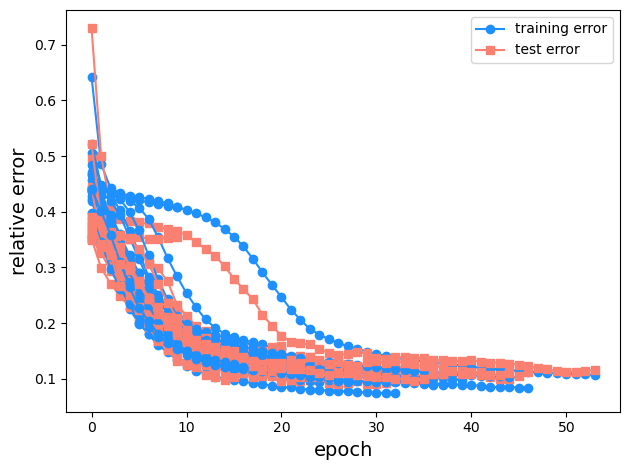

In [16]:
plot_errors(results_das)

### Get training results

In [17]:
# select the surrogate with the lowest test error
epoch_stop = results_das['epoch_stop']
test_errors = np.array(results_das['errors'])[:, :, 1]
test_errors = [error[epoch_stop[idx]] for idx, error in enumerate(test_errors)]
best_idx = np.argmin(test_errors)
das_surrogate = results_das['surrogate'][best_idx]
C_das = results_das['C_das'][best_idx]

# compute the active subspace on the training and test data
W_1 = results_das['projection_matrix'][best_idx]
y_das_train = np.dot(W_1.T, params_train.T).T
y_das_test = np.dot(W_1.T, params_test.T).T

### Recreate the eigenvalue plots

Plot the eigenvalues with confidence intervals. If the replica ensemble contains non-converged networks, this will show up as unreasonably large confidence intervals.

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


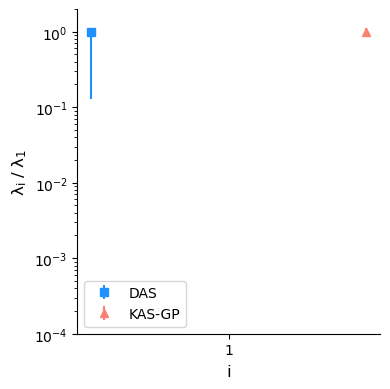

In [18]:
# number of eigenvalues to plot
n_vals = d

# basic analysisclass to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

# DAS eigenvalues
eigvals_C_das = results_das['eigvals'] 
eigvals_C_das = eigvals_C_das / np.mean(eigvals_C_das, axis=0)[0]
# eigenvalues averaged over the n_rep replica networks
mean_eigval_das = np.mean(eigvals_C_das[:, 0:n_vals], axis=0)
# compute confidence intervals
lower, upper = analysis.get_confidence_intervals(eigvals_C_das[:, 0:n_vals])
y_err_das = np.array([mean_eigval_das - lower, upper - mean_eigval_das])

# Load GP results from file
GP_eigvals = pd.read_csv('./GP_eigvals/scaled_eigen_results_epoxy_%s.csv' % (QoI,))
GP_mean = GP_eigvals['Eigenval_mean'].values
GP_std = GP_eigvals['Eigenval_std'].values

# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', ylim=[1e-4, 2])
ax1.set_ylabel(r'$\lambda_i\;/\;\lambda_1$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
offset = 0.1
ax1.errorbar(np.arange(1, n_vals + 1)-offset, mean_eigval_das, 
             yerr = y_err_das, fmt='s', color='dodgerblue', label='DAS')
ax1.errorbar(np.arange(1, n_vals + 1)+offset, GP_mean[0:n_vals], 
             yerr = GP_std[0:n_vals], fmt='^', color='salmon', label='KAS-GP')
plt.legend(loc=0)
ax1.set_xticks(np.arange(1, n_vals + 1, 1))
sns.despine(top=True)
plt.tight_layout()

fig.savefig('./images/epoxy_eigvals_d%d.png' % (d,))

### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [19]:
# run the surrogate at a number of random inputs locations drawn from U[-1, 1]
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
das_samples_pred = np.zeros(n_mc)
for i in range(n_mc):
    das_samples_pred[i] = das_surrogate.predict(pred_inputs[i])

In [20]:
# active subspace at prediction inputs x
y_val_das = np.dot(W_1.T, pred_inputs.T).T

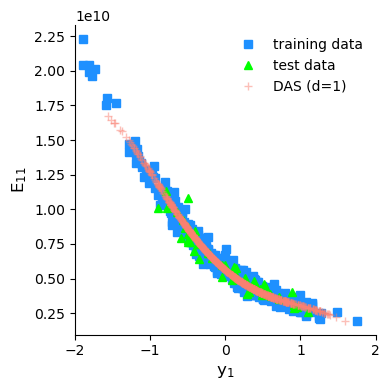

In [21]:
# QoI labels
lbl = {'E11': r'$E_{11}$', 'poisson': r'Poisson ratio'}

# plot DAS surrogate
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111,  xlim=[-2,2])    #E11 range
#ax = fig.add_subplot(111, ylim = [0.15, 0.45], xlim= [-2, 2]) # Poisson range
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_ylabel(lbl[QoI], fontsize=12)
ax.plot(y_das_train[:,0], samples_train, 's', color='dodgerblue', label='training data') 
ax.plot(y_das_test[:,0], samples_test, '^', color='lime', label='test data') 
ax.plot(y_val_das[:,0], das_samples_pred, '+', color='salmon', label='DAS (d=%d)' % d, alpha=0.5)
leg = ax.legend(loc=0, frameon=False)
leg.set_draggable(True)
sns.despine(top=True)
plt.tight_layout()
plt.savefig('./images/epoxy_surrogate_d%d_%s.png' % (d, QoI, ))

### Recreate the global-derivative based sensitivity plots

In [22]:
GP_results = pd.read_csv('./GP_SA/sensitivity_indices_epoxy_%s.csv' % (QoI,))

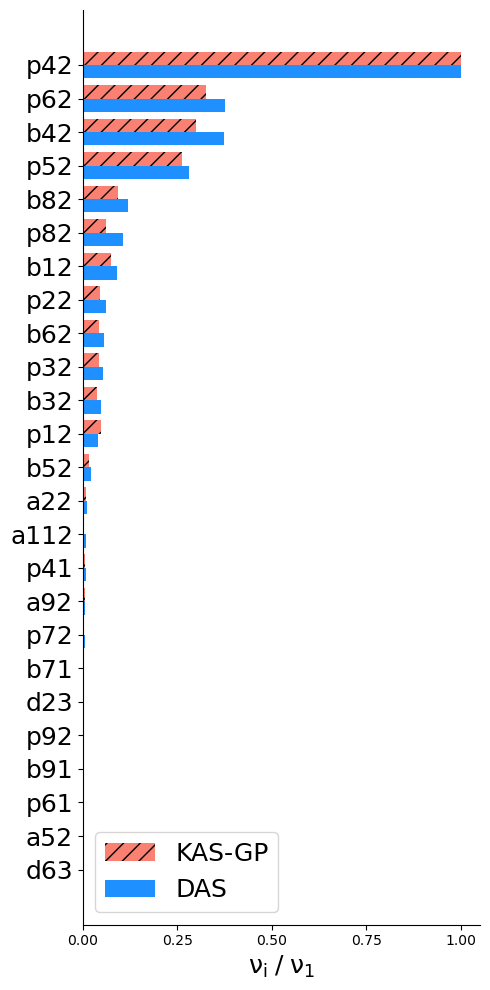

In [23]:
# plot sensitivity indices with CIs
plot_sensitivity(results_das, param_names, bar2 = GP_results)

### Compare epistemic with aleatoric uncertainty

Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate
done


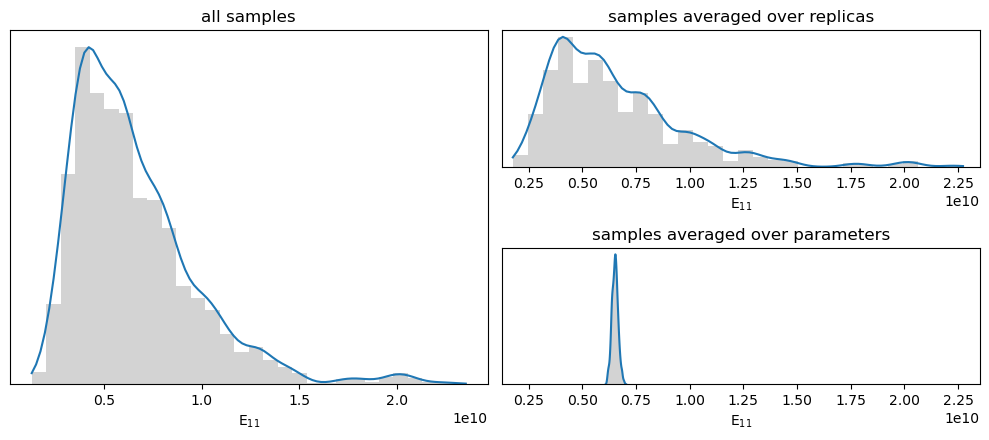

In [24]:
plot_dist(output, lbl[QoI])

### (Non-Gaussian) stats with bootstrapping

In [25]:
n_bootstap = 10 ** 5
n_samples = output.size

mean = np.zeros(n_bootstap)
std = np.zeros(n_bootstap)
skew = np.zeros(n_bootstap)
kurt = np.zeros(n_bootstap)

output = output.flatten() 

for i in tqdm(range(n_bootstap)):
    # resample with replacement
    idx = np.random.randint(0, n_samples, n_samples)
    # recompute moments
    mean[i] = np.mean(output[idx])
    std[i] = np.std(output[idx])
    skew[i] = stats.skew(output[idx])
    kurt[i] = stats.kurtosis(output[idx])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:45<00:00, 604.96it/s]


In [26]:
lower_mean, upper_mean = analysis.get_confidence_intervals(mean.reshape([-1,1]))
lower_std, upper_std = analysis.get_confidence_intervals(std.reshape([-1,1]))
lower_skew, upper_skew = analysis.get_confidence_intervals(skew.reshape([-1,1]))
lower_kurt, upper_kurt = analysis.get_confidence_intervals(kurt.reshape([-1,1]))

In [27]:
print("Mean: %.2e (%.2e/%.2e)" % (np.mean(output), lower_mean, upper_mean))
print("Std dev: %.2e (%.2e/%.2e)" % (np.std(output), lower_std, upper_std))
print("Skew: %.2f (%.3f/%.3f)" % (stats.skew(output), lower_skew, upper_skew))
print("Kurt: %.2f (%.2f/%.2f)" % (stats.kurtosis(output), lower_kurt, upper_kurt))
print("N_samples = %d" % n_samples)

Mean: 6.54e+09 (6.49e+09/6.59e+09)
Std dev: 3.22e+09 (3.16e+09/3.29e+09)
Skew: 1.61 (1.541/1.666)
Kurt: 3.76 (3.45/4.04)
N_samples = 10000
